## Imports

In [67]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import svm

import pandas as pd
import numpy as np

from datetime import datetime
import time

## Data laoding from CSV
### Stockdata
* Load data from CSV

In [68]:
stock_list = pd.read_csv('log_returns_yahoo.csv')
date = pd.Series(stock_list['date'])
stock_list.drop(['date'],axis=1,inplace=True)
stock_data = {}

for symbol in stock_list:
    # data =  pd.Series(stock_list[symbol])
    df = pd.DataFrame({'adj_close': stock_list[symbol], 'date': date})
    # df = df.set_index(date)
    stock_data[symbol] = df

print(stock_data[list(stock_data.keys())[0]].head)

<bound method NDFrame.head of       adj_close        date
0     -0.017192  2011-01-04
1      0.006721  2011-01-05
2     -0.023234  2011-01-06
3     -0.025795  2011-01-07
4      0.010995  2011-01-10
...         ...         ...
3426  -0.007168  2024-02-22
3427  -0.007220  2024-02-23
3428  -0.036905  2024-02-26
3429   0.014926  2024-02-27
3430   0.000000  2024-02-28

[3431 rows x 2 columns]>


<Axes: xlabel='adj_close', ylabel='date'>

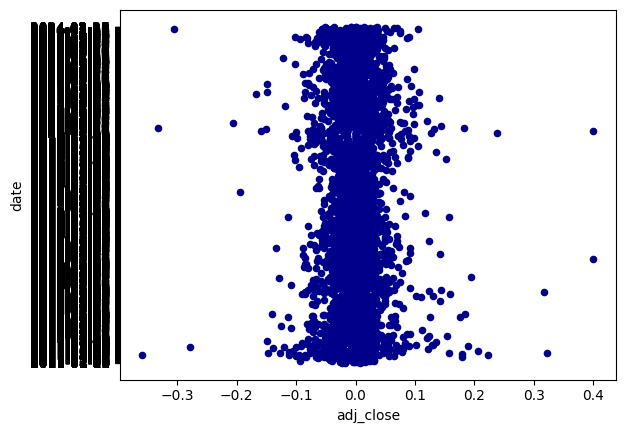

In [69]:
# visualize one stock
stock_data[list(stock_data.keys())[0]].plot.scatter(x='adj_close',y='date',c='DarkBlue')

### Short-selling-reports

In [70]:
short_list = pd.read_excel('stocks_with_listings.xlsx')
print(short_list.head)

<bound method NDFrame.head of      Unnamed: 0     Research Source       Date                       Stock  \
0             0  Kerrisdale Capital 2024-02-13                   Altimmune   
1             1  Kerrisdale Capital 2023-10-10               Joby Aviation   
2             2  Kerrisdale Capital 2023-09-18                      Tilray   
3             3  Kerrisdale Capital 2023-06-12                 Carvana Co.   
4             4  Kerrisdale Capital 2023-03-23  Uranium Energy Corporation   
..          ...                 ...        ...                         ...   
324         324    Iceberg Research 2015-02-15         Noble Group Limited   
325         325  J Capital Research 2024-01-18                  Hut 8 Corp   
326         326                 NaN 2023-11-30             ISPR Technology   
327         327                 NaN 2023-11-21    Microvast Holdings, Inc.   
328         328                 NaN 2023-06-27            American Lithium   

    SYMBOL  Data Source  Shortsel

## Label Rows
* read time shifted `adj_close` into `signal` such that it can be compared to current date in one row without reverse lookupQQ
* compare previous day and set 1 if stock has risen

In [71]:
# label function
def label_row(row):
    if (row['signal'] - row['adj_close']) > 0:
        return 1
    else:
        return 0
def label_df(df):
    df['signal'] = df['adj_close'].shift(1)
    df.fillna(0)
    df['signal'] = df.apply(label_row,axis=1)
    return df

In [72]:
for i in stock_data:
    stock_data[i] = label_df(stock_data[i])

## Create Bands

In [73]:
for i in stock_data:
    df = stock_data[i]
    if(df['signal'].shape[0] < 10):
        print(i)
        print(df['signal'].shape)

In [74]:
# print(stock_data['DWAC']['date'][0])
# a = pd.Timestamp(short_list.loc[short_list['SYMBOL'] == 'DWAC']['Date'].values[0])
# print(int(time.mktime(a.timetuple())))
# print(stock_data['DWAC'].loc[stock_data['DWAC']['date'] == 1710201600])

In [75]:
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

In [76]:
def timestamp_to_datetime(row):
    return datetime.strptime(row['date'], '%Y-%m-%d')

for index, row in short_list.iterrows():
    symbol = row['SYMBOL']
    date_report = row['Date']
    if symbol in list(stock_data.keys()):
        stock_df = stock_data[symbol]
        stock_df_a = stock_df
        stock_df['date'] = stock_df.apply(timestamp_to_datetime,axis=1)
        stock_start_date = nearest(np.array(stock_df['date']),date_report)
        # print(stock_start_date == date_report)
        condition = stock_df['date'] == stock_start_date
        print(type(stock_df['date']))
        print(type(stock_start_date))
# # Sample DataFrame
# data = {'A': [1, 2, 3, 4, 5],
#         'B': [6, 7, 8, 9, 10]}
# df = pd.DataFrame(data)

# # Condition
# condition = df['A'] == 3  # Change this condition to match your criteria

# # Find the index where the condition is first True
# start_index = df.index[condition][0]

# # Get all rows from start_index till the end
# result = df.iloc[start_index:]

# print(result)

        

<class 'pandas.core.series.Series'>
<class 'numpy.datetime64'>
<class 'pandas.core.series.Series'>
<class 'numpy.datetime64'>
<class 'pandas.core.series.Series'>
<class 'numpy.datetime64'>
<class 'pandas.core.series.Series'>
<class 'numpy.datetime64'>
<class 'pandas.core.series.Series'>
<class 'numpy.datetime64'>
<class 'pandas.core.series.Series'>
<class 'numpy.datetime64'>
<class 'pandas.core.series.Series'>
<class 'numpy.datetime64'>
<class 'pandas.core.series.Series'>
<class 'numpy.datetime64'>
<class 'pandas.core.series.Series'>
<class 'numpy.datetime64'>
<class 'pandas.core.series.Series'>
<class 'numpy.datetime64'>
<class 'pandas.core.series.Series'>
<class 'numpy.datetime64'>
<class 'pandas.core.series.Series'>
<class 'numpy.datetime64'>
<class 'pandas.core.series.Series'>
<class 'numpy.datetime64'>
<class 'pandas.core.series.Series'>
<class 'numpy.datetime64'>
<class 'pandas.core.series.Series'>
<class 'numpy.datetime64'>
<class 'pandas.core.series.Series'>
<class 'numpy.datet

## Create Testsplit

In [77]:
max_abs_scaler = preprocessing.MaxAbsScaler()
a = []
model_dict = {}
for index, row in short_list.iterrows():
    if row['SYMBOL'] in list(stock_data.keys()):
        report_release_date =  row['Date']
        #todo replace occurances of i with symbol
        i = symbol
        # read df into np.array
        X = np.array(stock_data[i].drop(['signal'],axis=1))
        X = max_abs_scaler.fit_transform(X)
        Y = np.array(stock_data[i]['signal'])

        # split
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)


        model_dict[i] = {}
        model_dict[i]['X Train'] = X_train
        model_dict[i]['X Test'] = X_test
        model_dict[i]['Y Train'] = y_train
        model_dict[i]['Y Test'] = y_test
        
        model = svm.SVC(kernel='rbf',decision_function_shape='ovo')
        # model = svm.SVC(kernel='linear')
        # model = svm.SVC(kernel='linear',decision_function_shape='ovo')
        # model = svm.SVC(kernel='rbf',decision_function_shape='ovo')
        # model = svm.SVC(kernel='poly')
        # model = svm.SVC(kernel='poly',decision_function_shape='ovo')
        # model = svm.SVC(kernel='sigmoid')
        # model = svm.SVC(kernel='sigmoid',decision_function_shape='ovo')

        # fit and test
        count = count + 1
        try:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            model_dict[i]['Y Prediction'] = y_pred
            #print("SVM Model Info for Ticker: "+i)
            #print("Accuracy:",metrics.accuracy_score(Model_Dict[i]['Y Test'], Model_Dict[i]['Y Prediction']))
            model_dict[i]['Accuracy'] = metrics.accuracy_score(model_dict[i]['Y Test'], model_dict[i]['Y Prediction'])
            #print("Precision:",metrics.precision_score(Model_Dict[i]['Y Test'], Model_Dict[i]['Y Prediction'],pos_label=str(1),average="macro"))
            model_dict[i]['Precision'] = metrics.precision_score(model_dict[i]['Y Test'], model_dict[i]['Y Prediction'],pos_label=str(1),average="macro")
            #print("Recall:",metrics.recall_score(Model_Dict[i]['Y Test'], Model_Dict[i]['Y Prediction'],pos_label=str(1),average="macro"))
            model_dict[i]['Recall'] = metrics.recall_score(model_dict[i]['Y Test'], model_dict[i]['Y Prediction'],pos_label=str(1),average="macro")
            #print("#################### \n")
        except: 
            a.append(i)


ValueError: could not convert string to float: '2011-01-04'

In [ ]:
for i in stock_data:
    #todo is this rly smart
    stock_data[i]['Returns'] = np.log(stock_data[i]['adj_close']/stock_data[i]['adj_close'].shift(1)) 

    prediction_length = len(model_dict[i]['Y Prediction'])

    stock_data[i]['SVM Signal'] = 0
    stock_data[i]['SVM Returns'] = 0
    stock_data[i]['Total Strat Returns'] = 0
    stock_data[i]['Market Returns'] = 0

    Signal_Column = stock_data[i].columns.get_loc('SVM Signal')
    Strat_Column = stock_data[i].columns.get_loc('SVM Returns')
    Return_Column = stock_data[i].columns.get_loc('Total Strat Returns')
    Market_Column = stock_data[i].columns.get_loc('Market Returns')
        
    stock_data[i].iloc[-prediction_length:,Signal_Column] = list(map(int,model_dict[i]['Y Prediction']))
    stock_data[i]['SVM Returns'] = stock_data[i]['SVM Signal'] * stock_data[i]['Returns'].shift(1)

    stock_data[i].iloc[-prediction_length:,Return_Column] = np.nancumsum(stock_data[i]['SVM Returns'][-prediction_length:])
    stock_data[i].iloc[-prediction_length:,Market_Column] = np.nancumsum(stock_data[i]['Returns'][-prediction_length:])
    # print(stock_data[i]['Total Strat Returns'].head)

    # model_dict[i]['Sharpe_Ratio'] = (stock_data[i]['Total Strat Returns'][-1] - stock_data[i]['Market Returns'][-1])/ \
    #                 np.nanstd(stock_data[i]['Total Strat Returns'][-prediction_length:])

KeyError: '1228.HK'

,date,adj_close,signal
0,2024-03-12,203.205933,None
1,2024-03-13,202.179993,None
2,2024-03-14,199.729996,None
3,2024-03-15,200.199997,None
4,2024-03-18,201.199997,None


In [ ]:
print(a)
mydict = [{'a': 1, 'b': 2, 'c': 3, 'd': 4},

          {'a': 100, 'b': 200, 'c': 300, 'd': 400},

          {'a': 1000, 'b': 2000, 'c': 3000, 'd': 4000}]

df = pd.DataFrame(mydict)

print(df)
# print(df.iloc[1:,1])
print('------')


2022-04-20 00:00:00
      a     b     c     d
0     1     2     3     4
1   100   200   300   400
2  1000  2000  3000  4000
------
   A   B
2  3   8
3  4   9
4  5  10
